# Job Requirements

# Imports, Global Variables & Utility Functions

In [45]:
# built-in packages
import os
import pickle
import time
from pprint import pprint
from typing import List, Dict, Tuple, Union, Optional, Any 
import posixpath
import json
import regex as re
import ast
import js2py

# note (source: phind.ai): we are not using urllib due its unpredictability. 
#       for example, if the base url doesn't have a trailing slash,
#       urllib will not join the base url with the rel\ative url correctly.
#       Moreover, if the second url has a leading slash, urllib will ignore the base url.
# from urllib.parse import urljoin, 

# pip-installed packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
from benedict import benedict

In [46]:
# global variables
COUNTRIES = ['india', 'uae']
BASE_OUTPUT_URL = 'outputs'
EXCEL_DIR = 'excel_files'
CSV_DIR = 'csv_files'

# global constants
BASE_URL = "https://www.zomato.com/"

In [47]:
def save_pkl(content_to_be_saved, path) -> None:
    """
    Save the given content to a file using pickle serialization.

    Args:
        content_to_be_saved: Any serializable object.
        path (str): The full path to the file where the data will be saved.

    Example:
        >>> save_pkl({'name': 'John', 'age': 30}, 'data.pkl')

    Returns:
        None

    Notes:
        "path" could either mean relative path or absolute path.
    """
    with open(path, 'wb') as f:
        pickle.dump(content_to_be_saved, f)

def load_pkl(path:str) -> Union[bool, any]:
    """
    Load data from a file using pickle deserialization.

    Args:
        path (str): The full path to the file to be loaded.

    Example:
        >>> loaded_data = load_pkl('data.pkl')

    Returns:
        The loaded content if the file exists, or False if the file does not exist.

    Notes:
        "path" could either mean relative path or absolute path.
    """
    if not os.path.exists(path):
        return False
    with open(path, 'rb') as f:
        content = pickle.load(f)
    return content

def force_load_pkl(path:str, dtype:str='dict') -> any:
    """
    Load data from a file using pickle deserialization. If the file does not exist,
    create an empty file and return an empty dictionary or list based on the specified data type.

    Args:
        path (str): The full path to the file to be loaded or created.
        dtype (str, optional): The data type to create if the file does not exist ('dict' or 'list').

    Example:
        >>> loaded_data = force_load_pkl('data.pkl', dtype='dict')

    Returns:
        The loaded content if the file exists, or an empty dictionary or list if the file does not exist.

    Notes:
        "path" could either mean relative path or absolute path.
    """
    try:
        content = load_pkl(path)
        return content
    except Exception as e:
        if dtype == 'list':
            save_pkl([], path)
            return []
        else:
            save_pkl({}, path)
            return {}

def join_paths(base_path:str, *relative_paths:str) -> str:
    """
    Join two paths and normalize the result.

    Args:
        base_directory (str): The base directory path.
        relative_path (str): The relative path to be joined.

    Example:
        >>> result = join_paths('/user/documents', 'files/myfile.txt')

    Returns:
        The normalized and joined path.

    Notes:
        More about naming standards for path components here: https://stackoverflow.com/a/2235762
    """
    return os.path.normpath(os.path.join(base_directory, relative_path))

def change_sep(path:str, new_sep:str, old_sep:str=os.path.sep) -> str:
    """
    Change the path separator in a given path and normalize the result.

    Args:
        path (str): The input path.
        new_sep (str): The new path separator to use.
        old_sep (str, optional): The old path separator to replace (default is os.path.sep).

    Example:
        >>> result = change_sep('path/to/change', '/', '\\')

    Returns:
        The path with the new separator, normalized.

    Notes:
        Source 1: https://stackoverflow.com/questions/18707338/print-raw-string-from-variable-not-getting-the-answers#:~:text=To%20turn%20a%20variable%20to%20raw%20str%2C%20just%20use
        Source 2: https://mail.python.org/pipermail/tutor/2011-July/084788.html
    """
    return os.path.normpath(rf"{path}").replace(old_sep, new_sep)


In [48]:
def save_df(df:pd.DataFrame, file_name_without_ext:str, to_excel:bool=True, to_csv:bool=True) -> None:
    """
    Save a dataframe to excel and csv files.
    """
    excel_path = join_paths(BASE_OUTPUT_URL, EXCEL_DIR, file_name_without_ext + '.xlsx')
    csv_path = join_paths(BASE_OUTPUT_URL, CSV_DIR, file_name_without_ext + '.csv')
    
    # check if the paths exist, and if not, create them
    if not os.path.exists(os.path.dirname(excel_path)):
        os.makedirs(os.path.dirname(excel_path))
    if not os.path.exists(os.path.dirname(csv_path)):
        os.makedirs(os.path.dirname(csv_path))

    if to_excel:
        df.to_excel(os.path.join(BASE_OUTPUT_URL, EXCEL_DIR, file_name_without_ext + '.xlsx'), index=False)
    if to_csv:
        df.to_csv(os.path.join(BASE_OUTPUT_URL, CSV_DIR, file_name_without_ext + '.csv'), index=False)

In [65]:
def _conversion_logic(v) -> Any:
    if isinstance(v, str):
        try:
            # convert into a dict/list if it's a JSON string
            v = json.loads(v)  
        except json.JSONDecodeError:
            # leave value as is otherwise
            pass  
    if isinstance(v, dict) or isinstance(v, list):
        # convert dict's/list's strings using _recurse_convert_collections function 
        return _recurse_convert_collections(v)  
    else:
        # if it's not a string, dict, or list, leave value as is
        return v

def _recurse_convert_collections(data:Union[dict, list]) -> Union[dict, list]:
    try:
        iterable = data.items() if isinstance(data, dict) else enumerate(data)
    except:
        raise('The input data is not a dict, or list.')
    
    for k_or_i, v in iterable:
        data[k_or_i] = _conversion_logic(v)

    return data

def data_to_benedict_dicts(data:Union[str, dict, List[dict]]) -> Union[dict, List[dict]]:
    if isinstance(data, str):
        try:
            data = json.loads(data)
        except json.JSONDecodeError:
            raise('The input data is not a valid JSON string.')
    
    if isinstance(data, dict) or isinstance(data, list):
        json_dict_or_list = _recurse_convert_collections(data)
        return json_dict_or_list
    else:
        raise('The input data is not a valid JSON string, dict, or list.')

In [50]:
def dict_find_key(nested_dict, target_key):
    for key, value in nested_dict.items():
        if key == target_key:
            return value
        if isinstance(value, dict):
            result = dict_find_key(value, target_key)
            if result is not None:
                return result
    return None

def dict_find_and_replace(nested_dict, target_key, new_value):
    for key, value in nested_dict.items():
        if key == target_key:
            nested_dict[key] = new_value
        elif isinstance(value, dict):
            nested_dict[key] = dict_find_and_replace(value, target_key, new_value)
    return nested_dict


# Main Functions

# Main Code

In [51]:
for country in COUNTRIES:
    # create the country url
    country_url = posixpath.join(BASE_URL, country)
    print(f"Current Country URL: {country_url}")

    # use beautifulsoup to parse the html content
    country_html = requests.get(country_url, headers={'User-Agent': 'Mozilla/5.0'}).text
    country_soup = BeautifulSoup(country_html, 'html.parser')

    # get the list of cities
    cities = country_soup.select('div.states-container > div > div > div h5')
    cities = [city.text.strip().split(' Restaurants')[0] for city in cities]
    print(cities)
    
    # create the city url
    for i, city in enumerate(cities):
        city_url = posixpath.join(BASE_URL, city)
        print(f"Current City URL: {city_url}")
        break
    break


Current Country URL: https://www.zomato.com/india
['Agra', 'Ahmedabad', 'Ajmer', 'Alappuzha', 'Allahabad', 'Amravati', 'Amritsar', 'Aurangabad', 'Bengaluru', 'Bhopal', 'Bhubaneswar', 'Chandigarh', 'Chennai', 'Coimbatore', 'Cuttack', 'Darjeeling', 'Dehradun', 'Delhi NCR', 'Dharamshala', 'Gangtok', 'Goa', 'Gorakhpur', 'Guntur', 'Guwahati', 'Gwalior', 'Haridwar', 'Hyderabad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jammu', 'Jamnagar', 'Jamshedpur', 'Jhansi', 'Jodhpur', 'Junagadh', 'Kanpur', 'Khajuraho', 'Khamgaon', 'Kharagpur', 'Kochi', 'Kolhapur', 'Kolkata', 'Kota', 'Lucknow', 'Ludhiana', 'Madurai', 'Manali', 'Mangalore', 'Manipal', 'Meerut', 'Mumbai', 'Mussoorie', 'Mysore', 'Nagpur', 'Nainital', 'Nashik', 'Neemrana', 'Ooty', 'Palakkad', 'Patiala', 'Patna', 'Puducherry', 'Pune', 'Pushkar', 'Raipur', 'Rajkot', 'Ranchi', 'Rishikesh', 'Salem', 'Shimla', 'Siliguri', 'Srinagar', 'Surat', 'Thrissur', 'Tirupati', 'Trichy', 'Trivandrum', 'Udaipur', 'Vadodara', 'Varanasi', 'Vellore', 'Vijay

In [52]:
import requests

cookies = {
    'PHPSESSID': '4b96bb7a198a94a216ff3c994d05a499',
    'fre': '0',
    'rd': '1380000',
    'zl': 'en',
    'fbtrack': '6afeb18328d78ee467b7f1fd3f8f952f',
    'uspl': 'true',
    'G_ENABLED_IDPS': 'google',
    'fbcity': '34',
    'ltv': '34',
    'lty': '34',
    'locus': '%7B%22addressId%22%3A0%2C%22lat%22%3A27.18%2C%22lng%22%3A78.02%2C%22cityId%22%3A34%2C%22ltv%22%3A34%2C%22lty%22%3A%22city%22%2C%22fetchFromGoogle%22%3Afalse%2C%22dszId%22%3A14225%2C%22fen%22%3A%22Agra%22%7D',
    'ak_bmsc': '3A3756FA2C3EAADCD1917A910E057D31~000000000000000000000000000000~YAAQlWp7XOyA0JWKAQAAtsWcrBW0d0YVMOzlKBqmlNubDQUUMFhLLHkAxymev9OAublvvSCEtLsGluFkcJl9dkTiHg2fhszMDLq0AwJ/VPa77AluDzD1yQGJVQIqA4ahXn7EHcKna+hq5pp4Jh3kKDMqNk7o4HXBIw9XcvQFd5V+8IOXAoVo0lPIsHN7GD2q3K/W2HlSPDI9cw/mdabPF3PrKm9luRyFLl6X9chmUW124STmwQ0x9tTBVbug0V5tVSzTnKpXlAJVhrPI0FRpimydPvVbE8vlXfbkw8eHITtnKApHgpwZ2uFfvMFNUQ+a347wSQKw742QtEyjLdA8y7AYjTzV4CgXptG//0wCmKFj9+r9rJwcwSRTAg==',
    'csrf': 'c7dc25cc63e3cac1235af2110cb2f597',
    'AWSALBTG': 'ffYYXrjQyzjhb8ij6ptwK4RPVbofNBnJTHAmvAB6XTE1zQrzwbKo6mRAUOo5G2J7GoqN/nlucvRIAQBTZQ+JnokQA/UicsrZPQGKCpGJMR/QmGEpLsIQ2Yq9nFn1c3FHRA9ziEeANUp2qDPVbJ4pvl/qOjsi0KKR2nmjsJzJ3J2a',
    'AWSALBTGCORS': 'ffYYXrjQyzjhb8ij6ptwK4RPVbofNBnJTHAmvAB6XTE1zQrzwbKo6mRAUOo5G2J7GoqN/nlucvRIAQBTZQ+JnokQA/UicsrZPQGKCpGJMR/QmGEpLsIQ2Yq9nFn1c3FHRA9ziEeANUp2qDPVbJ4pvl/qOjsi0KKR2nmjsJzJ3J2a',
}

headers = {
    'authority': 'www.zomato.com',
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.9,en-GB;q=0.8',
    'content-type': 'application/json',
    # 'cookie': 'PHPSESSID=4b96bb7a198a94a216ff3c994d05a499; fre=0; rd=1380000; zl=en; fbtrack=6afeb18328d78ee467b7f1fd3f8f952f; uspl=true; G_ENABLED_IDPS=google; fbcity=34; ltv=34; lty=34; locus=%7B%22addressId%22%3A0%2C%22lat%22%3A27.18%2C%22lng%22%3A78.02%2C%22cityId%22%3A34%2C%22ltv%22%3A34%2C%22lty%22%3A%22city%22%2C%22fetchFromGoogle%22%3Afalse%2C%22dszId%22%3A14225%2C%22fen%22%3A%22Agra%22%7D; ak_bmsc=3A3756FA2C3EAADCD1917A910E057D31~000000000000000000000000000000~YAAQlWp7XOyA0JWKAQAAtsWcrBW0d0YVMOzlKBqmlNubDQUUMFhLLHkAxymev9OAublvvSCEtLsGluFkcJl9dkTiHg2fhszMDLq0AwJ/VPa77AluDzD1yQGJVQIqA4ahXn7EHcKna+hq5pp4Jh3kKDMqNk7o4HXBIw9XcvQFd5V+8IOXAoVo0lPIsHN7GD2q3K/W2HlSPDI9cw/mdabPF3PrKm9luRyFLl6X9chmUW124STmwQ0x9tTBVbug0V5tVSzTnKpXlAJVhrPI0FRpimydPvVbE8vlXfbkw8eHITtnKApHgpwZ2uFfvMFNUQ+a347wSQKw742QtEyjLdA8y7AYjTzV4CgXptG//0wCmKFj9+r9rJwcwSRTAg==; csrf=c7dc25cc63e3cac1235af2110cb2f597; AWSALBTG=ffYYXrjQyzjhb8ij6ptwK4RPVbofNBnJTHAmvAB6XTE1zQrzwbKo6mRAUOo5G2J7GoqN/nlucvRIAQBTZQ+JnokQA/UicsrZPQGKCpGJMR/QmGEpLsIQ2Yq9nFn1c3FHRA9ziEeANUp2qDPVbJ4pvl/qOjsi0KKR2nmjsJzJ3J2a; AWSALBTGCORS=ffYYXrjQyzjhb8ij6ptwK4RPVbofNBnJTHAmvAB6XTE1zQrzwbKo6mRAUOo5G2J7GoqN/nlucvRIAQBTZQ+JnokQA/UicsrZPQGKCpGJMR/QmGEpLsIQ2Yq9nFn1c3FHRA9ziEeANUp2qDPVbJ4pvl/qOjsi0KKR2nmjsJzJ3J2a',
    'origin': 'https://www.zomato.com',
    'referer': 'https://www.zomato.com/agra',
    'sec-ch-ua': '"Chromium";v="116", "Not)A;Brand";v="24", "Google Chrome";v="116"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36',
    'x-zomato-csrft': 'c7dc25cc63e3cac1235af2110cb2f597',
}

json_data = {
    'context': 'delivery',
    'filters': '{"searchMetadata":{"previousSearchParams":"{\\"PreviousSearchId\\":\\"3b79eef9-c768-4d84-b487-2a1fa60aae2f\\",\\"PreviousSearchFilter\\":[\\"{\\\\\\"category_context\\\\\\":\\\\\\"delivery_home\\\\\\"}\\",\\"\\"]}","postbackParams":"{\\"processed_chain_ids\\":[19748876,3400169,19468292,19183764,20470976,19461231,20129295,3400105,19382015],\\"shown_res_count\\":9,\\"search_id\\":\\"3b79eef9-c768-4d84-b487-2a1fa60aae2f\\"}","totalResults":1455,"hasMore":true,"getInactive":false},"dineoutAdsMetaData":{},"appliedFilter":[{"filterType":"category_sheet","filterValue":"delivery_home","isHidden":true,"isApplied":true,"postKey":"{\\"category_context\\":\\"delivery_home\\"}"}],"urlParamsForAds":{}}',
    'addressId': 0,
    'entityId': 34,
    'entityType': 'city',
    'locationType': '',
    'isOrderLocation': 1,
    'cityId': 34,
    'latitude': '27.1800000000000000',
    'longitude': '78.0200000000000000',
    'userDefinedLatitude': 27.18,
    'userDefinedLongitude': 78.02,
    'entityName': 'Agra',
    'orderLocationName': 'Agra',
    'cityName': 'Agra',
    'countryId': 1,
    'countryName': 'India',
    'displayTitle': 'Agra',
    'o2Serviceable': True,
    'placeId': '14225',
    'cellId': '4140058016516931584',
    'deliverySubzoneId': 14225,
    'placeType': 'DSZ',
    'placeName': 'Agra',
    'isO2City': True,
    'fetchFromGoogle': False,
    'fetchedFromCookie': True,
    'isO2OnlyCity': False,
    'address_template': [],
    'otherRestaurantsUrl': '',
}

response = requests.post('https://www.zomato.com/webroutes/search/home', cookies=cookies, headers=headers, json=json_data)

# Note: json_data will not be serialized by requests
# exactly as it was in the original request.
#data = '{"context":"delivery","filters":"{\\"searchMetadata\\":{\\"previousSearchParams\\":\\"{\\\\\\"PreviousSearchId\\\\\\":\\\\\\"3b79eef9-c768-4d84-b487-2a1fa60aae2f\\\\\\",\\\\\\"PreviousSearchFilter\\\\\\":[\\\\\\"{\\\\\\\\\\\\\\"category_context\\\\\\\\\\\\\\":\\\\\\\\\\\\\\"delivery_home\\\\\\\\\\\\\\"}\\\\\\",\\\\\\"\\\\\\"]}\\",\\"postbackParams\\":\\"{\\\\\\"processed_chain_ids\\\\\\":[19748876,3400169,19468292,19183764,20470976,19461231,20129295,3400105,19382015],\\\\\\"shown_res_count\\\\\\":9,\\\\\\"search_id\\\\\\":\\\\\\"3b79eef9-c768-4d84-b487-2a1fa60aae2f\\\\\\"}\\",\\"totalResults\\":1455,\\"hasMore\\":true,\\"getInactive\\":false},\\"dineoutAdsMetaData\\":{},\\"appliedFilter\\":[{\\"filterType\\":\\"category_sheet\\",\\"filterValue\\":\\"delivery_home\\",\\"isHidden\\":true,\\"isApplied\\":true,\\"postKey\\":\\"{\\\\\\"category_context\\\\\\":\\\\\\"delivery_home\\\\\\"}\\"}],\\"urlParamsForAds\\":{}}","addressId":0,"entityId":34,"entityType":"city","locationType":"","isOrderLocation":1,"cityId":34,"latitude":"27.1800000000000000","longitude":"78.0200000000000000","userDefinedLatitude":27.18,"userDefinedLongitude":78.02,"entityName":"Agra","orderLocationName":"Agra","cityName":"Agra","countryId":1,"countryName":"India","displayTitle":"Agra","o2Serviceable":true,"placeId":"14225","cellId":"4140058016516931584","deliverySubzoneId":14225,"placeType":"DSZ","placeName":"Agra","isO2City":true,"fetchFromGoogle":false,"fetchedFromCookie":true,"isO2OnlyCity":false,"address_template":[],"otherRestaurantsUrl":""}'
#response = requests.post('https://www.zomato.com/webroutes/search/home', cookies=cookies, headers=headers, data=data)

In [53]:
resp = requests.get('https://www.zomato.com/agra', headers={'User-Agent': 'Mozilla/5.0'})
resp.status_code

200

JSON.parse("{\"pages\":{\"current\":{\"name\":\"search\",\"pageTitle\":\"Checkout Best Food Places To Eat In Agra | Zomato\",\"pageDescription\":\"Looking for Best Food in Agra? Checkout the highest-rated restaurants in Agra and satisfy your food cravings now!\",\"pageUrl\":\"/agra\",\"title\":\"Checkout Best Food Places To Eat In Agra | Zomato\",\"isNoIndex\":false,\"ogTitle\":\"Checkout Best Food Places To Eat In Agra | Zomato\",\"ogDescription\":\"Looking for Best Food in Agra? Checkout the highest-rated restaurants in Agra and satisfy your food cravings now!\",\"ogPageUrl\":\"/agra\",\"subType\":\"delivery\",\"isMobile\":0,\"isTablet\":0,\"isOAuthV2Enabled\":false,\"useAuthSdkForLogin\":true,\"useAuthSdkForLogout\":false,\"gaPageType\":\"City\"},\"contact\":{\"contactPageBannerData\":[],\"snippetData\":[],\"formData\":{},\"buisinessEnquiriesData\":{}},\"gift\":{\"crystalData\":{}},\"goodbye\":{},\"restaurant\":{},\"awards\":{\"cities\":[],\"cityWinners\":[],\"currentCity\":{},\"loa
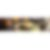
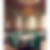
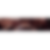
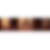

In [54]:
pattern = r'(JSON\.parse\(.*\);)'
matches = re.findall(pattern, resp.text)[0]
print(matches)

In [55]:
dictt = js2py.eval_js(matches).to_dict()
lst = dict_find_key(dictt, 'SECTION_SEARCH_RESULT')
lst = [adictt for adictt in lst if (dict_find_key(adictt, 'resId') is not None)]
# lst

In [56]:
new_json_data = dict_find_and_replace(json_data, 'shown_res_count', 100)

In [57]:
response = requests.post('https://www.zomato.com/webroutes/search/home', cookies=cookies, headers=headers, json=new_json_data)

In [58]:
len(response.json()['sections']['SECTION_SEARCH_RESULT'])

12

In [66]:
json_data = data_to_benedict_dicts(json_data)
pprint(json_data)

{'addressId': 0,
 'address_template': [],
 'cellId': 4140058016516931584,
 'cityId': 34,
 'cityName': 'Agra',
 'context': 'delivery',
 'countryId': 1,
 'countryName': 'India',
 'deliverySubzoneId': 14225,
 'displayTitle': 'Agra',
 'entityId': 34,
 'entityName': 'Agra',
 'entityType': 'city',
 'fetchFromGoogle': False,
 'fetchedFromCookie': True,
 'filters': {'appliedFilter': [{'filterType': 'category_sheet',
                                'filterValue': 'delivery_home',
                                'isApplied': True,
                                'isHidden': True,
                                'postKey': {'category_context': 'delivery_home'}}],
             'dineoutAdsMetaData': {},
             'searchMetadata': {'getInactive': False,
                                'hasMore': True,
                                'postbackParams': {'processed_chain_ids': [19748876,
                                                                           3400169,
                            

In [60]:
type(json_data)

dict

In [41]:
json_data = json_data.standardize()
pprint(json_data)

None


In [40]:
json_data.search('postkey', in_keys=True, in_values=False,
                  exact=True, case_sensitive=False)

[({'filterType': 'category_sheet', 'filterValue': 'delivery_home', 'isHidden': True, 'isApplied': True, 'postKey': {'category_context': 'delivery_home'}},
  'postKey',
  {'category_context': 'delivery_home'})]

In [51]:
benedict(json.loads(response.text))['sections.SECTION_SEARCH_RESULT[0].info']

{'resId': 3401744, 'name': 'The Salt Cafe Kitchen & Bar', 'image': {'url': 'https://b.zmtcdn.com/data/pictures/4/3401744/a5fe55d075d83d4c4d9915f2776d940e_featured_v2.jpg', 'urlWithParams': 'https://b.zmtcdn.com/data/pictures/4/3401744/a5fe55d075d83d4c4d9915f2776d940e_featured_v2.jpg?fit=around%7C108%3A108&crop=108%3A108%3B%2A%2C%2A'}, 'o2FeaturedImage': {'url': 'https://b.zmtcdn.com/data/pictures/4/3401744/3ddba5d2589a76c62fdcd9d8c8eaefc4_o2_featured_v2.jpg'}, 'rating': {'has_fake_reviews': 0, 'aggregate_rating': '4.6', 'rating_text': '4.6', 'rating_subtitle': 'Excellent', 'rating_color': '3F7E00', 'votes': '7,328', 'subtext': 'REVIEWS', 'is_new': False}, 'ratingNew': {'newlyOpenedObj': None, 'suspiciousReviewObj': None, 'ratings': {'DINING': {'rating_type': 'DINING', 'rating': '4.9', 'reviewCount': '5,296', 'reviewTextSmall': '5,296 Reviews', 'subtext': '5,296 Dining Reviews', 'color': '#1C1C1C', 'ratingV2': '4.9', 'subtitle': 'DINING', 'sideSubTitle': 'Dining Reviews', 'bgColorV2': {

In [28]:
city_html = requests.post('https://www.zomato.com/agra', ).text


'Visakhapatnam Restaurantschevron-right'

# Visualizing Functions' Return Values